<a href="https://colab.research.google.com/github/MasahiroAraki/SpeechRecognition/blob/master/Python/chap07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 限界は破れるか（２） ニューラルネットワーク

In [1]:
!pip install -U mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.4 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


## numpyを用いたニューラルネットのコーディング

ここでは Python の数値計算ライブラリ numpy を用いてニューラルネットのコーディングを行います。例題として、XOR関数をニューラルネットで実現します。

対象とするネットワークの構造を以下の図に示します。ここでは、コードが見やすくなるという理由で、入力に加えるバイアス（b, b2）を別に扱っています。

また、多階層に拡張が容易なように重みもw, w2と名付けています。


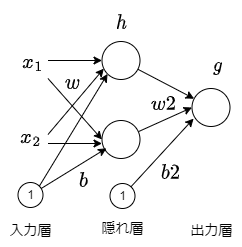

ここでは数学関数モジュール math と数値計算ライブラリ numpy を読み込んでおきます。

In [2]:
import math
import numpy as np

次に重み、バイアスの初期値を設定します。このコード内では、扱う行列・テンソルは numpy の ndarray です。

In [3]:
# 重みとバイアスの初期化
w = np.random.rand(2, 2)
b = np.array([np.random.rand(2)])
w2 = np.array([np.random.rand(2)])
b2 = np.array([np.random.rand(1)])

次にシグモイド関数とその導関数を定義します。ここでは、1つの数値を引数として与えると、その演算結果を返す関数として定義しておいて、 @np.vectorize というデコレータを付けることで、ベクトルが入力されたら、各要素に対して演算を行い、その結果をベクトルとして返せるようにします。

In [4]:
@np.vectorize
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

@np.vectorize
def sigmoid_derivative(x):
  return sigmoid(x) * (1 - sigmoid(x))

XOR関数の入力と正解は以下のように定義します。



In [5]:
X = np.array([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
y = np.array([0., 1., 1., 0.])

前向きの計算は以下のようになります。

In [6]:
# 前向き計算
def forward(x, w, b, w2, b2):
  s = w @ x.T + b
  h = sigmoid(s)
  z = w2 @ h.T + b2
  g = sigmoid(z)
  return s, h, z, g

学習を行うコードは以下のようになります。

In [7]:
# 学習率
rho = 1
# エポック数
epoch = 10000

for i in range(epoch):
  error = 0
  for x, t in zip(X, y):
    # 順伝播
    s, h, z, g = forward(x, w, b, w2, b2)
    # エラー計算
    error += 0.5 * np.power((t - g), 2)
    # 逆伝播
    delta_2 = -(t - g) * sigmoid_derivative(z)
    delta_w2 = rho * delta_2 * h
    delta_b2 = rho * delta_2
    delta_1 = delta_2 * w2 * sigmoid_derivative(s)
    delta_w = rho * np.outer(delta_1, x)
    delta_b = rho * delta_1
    # 重みとバイアスの更新
    w -= delta_w
    b -= delta_b
    w2 -= delta_w2
    b2 -= delta_b2
  # 一定のエポック数で誤差を表示
  if i%(epoch/10) == 0:
    print(f'epoch = {i} error = {error[0][0]/len(X)}')

epoch = 0 error = 0.14471775699382713
epoch = 1000 error = 0.07382763170064459
epoch = 2000 error = 0.06752720313496889
epoch = 3000 error = 0.06707021432912622
epoch = 4000 error = 0.06691010317109317
epoch = 5000 error = 0.06682925926266745
epoch = 6000 error = 0.0667807004386845
epoch = 7000 error = 0.06674838214294501
epoch = 8000 error = 0.06672535878251087
epoch = 9000 error = 0.0667081424412354


このコードでは、重みの初期値によってかなり結果が異なります。誤差が順調に減っている場合は、XOR関数が実現できているので、そのことを確認します。

In [8]:
for x in X:
  g = forward(x, w, b, w2, b2)
  print(f'input = {x}  result = {g[3][0][0]:.3f}')

input = [0. 0.]  result = 0.012
input = [0. 1.]  result = 0.484
input = [1. 0.]  result = 0.988
input = [1. 1.]  result = 0.484


Tensorflowライブラリを用いたコード

上記XOR関数の実現では、隠れ層のユニット数を少し多くすると成功することが多くなります。しかし、numpyを用いたコーディングではテンソルの次元数の変更は修正箇所が多くなりがちです。ニューラルネットのライブラリである Tensorflow を使うと、ネットワーク構造の変更が容易になります。

In [9]:
import tensorflow as tf
import numpy as np

# XORの入力データとラベル
x_train = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float32)
y_train = np.array([[0], [1], [1], [0]], dtype=np.float32)

# ネットワークの定義
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=(2,), activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# モデルのコンパイル
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# モデルの学習
model.fit(x_train, y_train, epochs=1000, verbose=0)

# テストデータでの予測
x_test = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float32)
predictions = model.predict(x_test)

# 予測結果の表示
for i in range(len(x_test)):
    print(f"Input: {x_test[i]}, Predicted Output: {predictions[i]}")


1/1 [==============================] - 0s 76ms/step
Input: [0. 0.], Predicted Output: [0.29813185]
Input: [0. 1.], Predicted Output: [0.6402039]
Input: [1. 0.], Predicted Output: [0.6180165]
Input: [1. 1.], Predicted Output: [0.4541909]


## 例題7.1

教科書では手入力した少数のデータでニューラルネットワークの学習を行っていますが、ここでは乱数を用いて発生させたデータを学習データとして、scikit-learnの[MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)を用いてニューラルネットワークの学習を行います。

データの準備と表示

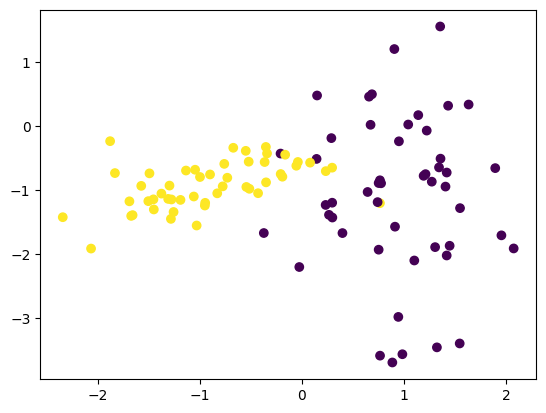

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier
from mlxtend.plotting import plot_decision_regions

X, y = make_classification(n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=23)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)

scikit-learnの[MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)で学習。パラメータはデフォルトとします。

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<Axes: >

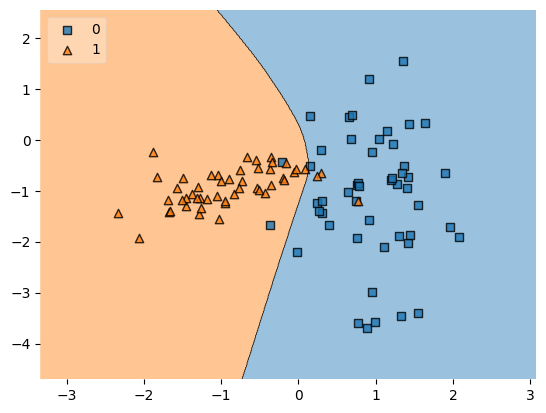

In [11]:
clf = MLPClassifier()
clf.fit(X,y)
plot_decision_regions(X=X, y=y, clf=clf, legend=2)

デフォルトの繰返し回数200回では誤差関数が収束していないという警告が出ています。インスタンス生成時の引数max_iterの値を少し大きく指定してみます。

<Axes: >

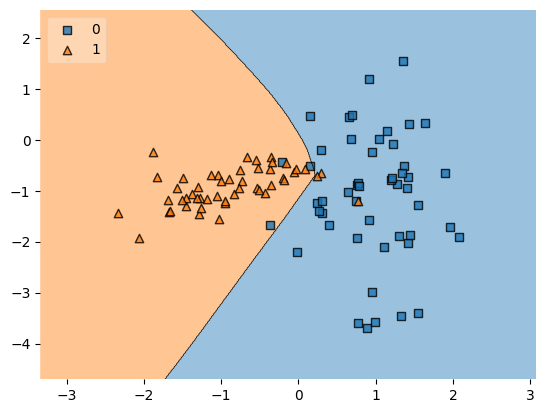

In [12]:
clf2 = MLPClassifier(max_iter=500)
clf2.fit(X,y)
plot_decision_regions(X=X, y=y, clf=clf2, legend=2)

識別面は変化していますが、性能はあまり変わらないように見えます。

# ニューラルネットワークのためのデータ表現

ここでは、MNISTとよばれる手描き数字データを使って、学習用のデータの扱い方を学びます。まず、以下のコードを実行し、MNISTデータをndarray形式で読み込みます。

In [13]:
import tensorflow as tf

#学習用画像、学習用画像の正解ラベル、評価用画像、評価用画像の正解ラベルが読み込まれる
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


機械学習におけるデータの表現はtensorを用います。tensorは任意の次元の可変長配列とみなすことができます。配列の次元にあたる概念はtensorではランクとよび、よく使われるランクは0から4です。


* ランク0: スカラー
* ランク1: ベクトル
* ランク2: 行列
* ランク3以上: 行列の集合

ランク2のtensorは1枚の画像データを表し、ランク3のtensorはMNISTの学習データ集合のように画像データの集合を表します（train_images.shapeの出力を確認してください）。



tensorの表現は、機械学習ライブラリではPythonのList形式ではなく、計算の高速化のため、numpyライブラリのndarray形式を用います。ndarrayで表現したtensorの基本属性は以下の3つです。


* ランク（数字並びの軸の数）：ndim
* 各軸の要素数：shape
* 要素の型：dtype

深層学習におけるデータ表現では、tensorの最初（0番目）の軸をsample axisとよび、データの並びを表します。たとえば以下の train_images では 60000個の28x28の画像が並んでいると解釈します。画像中の各ピクセルは0-255の整数値で表されています。



In [14]:
type(X_train)

numpy.ndarray

In [15]:
X_train.ndim

3

In [16]:
X_train.shape

(60000, 28, 28)

In [17]:
X_train.dtype

dtype('uint8')

tensorから特定の要素を取り出す場合は、indexを指定します。取り出した画像を表示するために、ここではmatplotlibライブラリを用いています。

(28, 28)


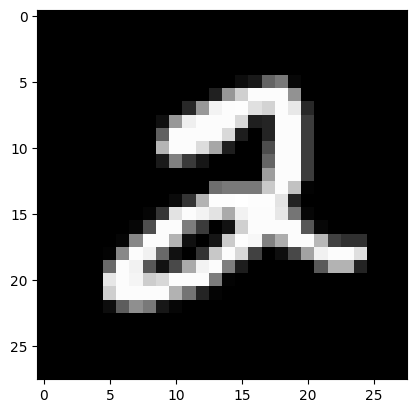

In [18]:
import matplotlib.pyplot as plt
digit = X_train[5]
print(digit.shape)
plt.imshow(digit, cmap='gray')
plt.show()

tensorから特定範囲のデータを取り出すにはスライスを用います。範囲の最後を指定しているindexに対応するデータ（この例の場合は20番のデータ）は含まれないことに注意してください。

In [19]:
digits = X_train[10:20]
print(digits.shape)

(10, 28, 28)


# Keras入門

## Kerasとは

TensorFlowを下位層のプラットフォームとした深層学習ライブラリです。

まず、train_imagesとtrain_labelsを使ってニューラルネットワークの学習を行い、次にtest_imagesとtest_labelsを使って性能を評価します。

最初にニューラルネットワークの構造を決めます。ニューラルネットワークはレイヤーの積み重ねからなります。レイヤーの種類として、ここではDenseを用いています。Denseは密結合の意味で、そのレイヤーの入力すべてと結合したユニットからなることを示します。最初の引数はそのレイヤーのユニット数です。また、引数activationの値でユニットの活性化関数を決めます。reluは$f(x)=max(0,x)$となる関数、softmaxは入力値の大小関係を保持しながら出力の総和が1となるように変換する関数です。

In [20]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

このネットワークに対して、以下の3つの要素を指定して学習可能にします。


* 最適化器
* 損失関数
* 学習やテストの進行をモニタするための指標



In [21]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

作成したニューラルネットワークの構造に合わせて入力の形式を変換します。また、各画素の値が0-255と大きいので、これを0-1に正規化します。

In [22]:
X_train = X_train.reshape((60000, 28*28))
X_train = X_train.astype('float32')/255
X_test = X_test.reshape((10000, 28*28))
X_test = X_test.astype('float32')/255

fitメソッドで学習を実行します。accuracy（正解率）の値が繰り返し毎に向上していることを確認してください。

In [23]:
model.fit(X_train, y_train, epochs=5, batch_size=128)

Epoch 1/5
469/469 [==============================] - 2s 2ms/step - loss: 0.2668 - accuracy: 0.9229
Epoch 2/5
469/469 [==============================] - 1s 2ms/step - loss: 0.1087 - accuracy: 0.9678
Epoch 3/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0723 - accuracy: 0.9785
Epoch 4/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0527 - accuracy: 0.9840
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0385 - accuracy: 0.9887


次に、学習に用いたのとは別のデータで評価します。accuracyの値が学習データより低くなっていますが、これはニューラルネットワークが学習データに対して過度に適応してしまっていることを示します。

In [24]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test acc:', test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.0736 - accuracy: 0.9779
test acc: 0.9779000282287598


# 画像認識実験

ここではTensorFlowのラッパライブラリであるKerasを用いて畳み込みネットワークによる画像認識実験を行います。Kerasでは畳み込み層やプーリング層がレイヤーとして用意されているので、レイヤーを積み重ねてモデルを作成し、学習用データを与えて学習、評価用データで評価という手順となります。

ライブラリの読み込み

In [25]:
import numpy as np
import tensorflow as tf

MNISTデータのロード

In [26]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

まず、入力をフラットな配列に変換します。また、元データでは濃淡が0から255までで表現されており、最大値が大きすぎるので、特徴の値の最大値を1とします。

In [27]:
# input image dimensions
img_rows, img_cols = 28, 28

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

正解を示すy_train, y_testの要素は0から9の数字で表されています。ニューラルネットの学習では、出力層のノード数を識別対象のクラス数に合わせ（2クラス問題のみ例外）、その出力と正解情報との差を最小にするように学習します。そのため、正解の数字を10次元のone-hotベクトル（正解の数字に対応する次元の値が1、それ以外の次元の値は0）に変換します。

In [28]:
Y_train = tf.keras.utils.to_categorical(y_train)
Y_test = tf.keras.utils.to_categorical(y_test)

ネットワークの構造は、畳み込み + プーリングを2回行った後、1次元に整形して3層の階層型ニューラルネットで識別を行うようにします。Modelクラスのsummaryメソッドでネットワークの構造を表示することができます。

In [29]:
n_out = len(Y_train[0])  # 10

model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape)) # 3x3のフィルタを16枚用意する
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2))) # 2x2の範囲で最大値をとる
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu')) # 3x3のフィルタを32枚用意する
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())  #1次元に成形
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(n_out, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense_4 (Dense)             (None, 128)              

学習に用いる最適化器はよく使われている AdamW を用います。

評価はテストデータの正解率で行います。

In [30]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.AdamW(),
              metrics = ['accuracy'])
model.fit(X_train, Y_train, epochs=5, batch_size=200)
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/5
300/300 [==============================] - 7s 3ms/step - loss: 0.3194 - accuracy: 0.9138
Epoch 2/5
300/300 [==============================] - 1s 3ms/step - loss: 0.0783 - accuracy: 0.9761
Epoch 3/5
300/300 [==============================] - 1s 3ms/step - loss: 0.0562 - accuracy: 0.9834
Epoch 4/5
300/300 [==============================] - 1s 4ms/step - loss: 0.0442 - accuracy: 0.9861
Epoch 5/5
300/300 [==============================] - 1s 4ms/step - loss: 0.0378 - accuracy: 0.9880
Test loss: 0.03594421222805977
Test accuracy: 0.9879999756813049


## 練習問題

例題7.1において、ネットワーク構造を変化させ、勾配消失が起きる状況を確認せよ。また、この勾配消失が起きたネットワークの活性化関数を変化させることで学習が可能になることを確認せよ。

## 解答例

<Axes: >

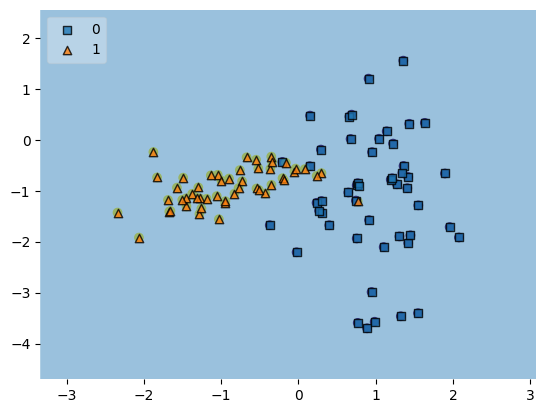

In [31]:
# 勾配消失が起きる設定
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier
from mlxtend.plotting import plot_decision_regions

X, y = make_classification(n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=23)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)

# 隠れ層のユニット数:4、階層数；6、活性化関数:シグモイド、エポック数:100000
clf3 = MLPClassifier(hidden_layer_sizes=(4,4,4,4,4,4), activation='logistic', learning_rate_init=0.001, max_iter=100000)
clf3.fit(X,y)
plot_decision_regions(X=X, y=y, clf=clf3, legend=2)

<Axes: >

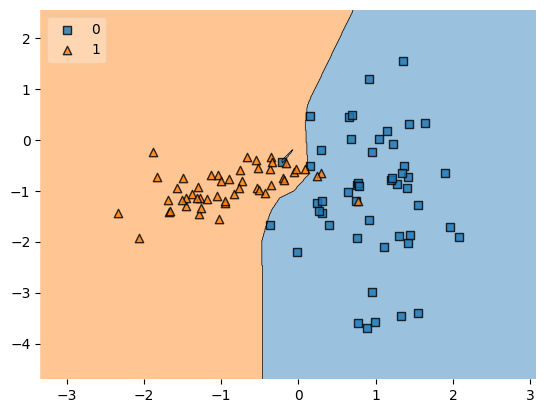

In [33]:
# 活性化関数を変更、エポック数を小さくする
# 隠れ層のユニット数:4、階層数；6、活性化関数:ReLU、エポック数:10000
clf4 = MLPClassifier(hidden_layer_sizes=(4,4,4,4,4,4), activation='relu', learning_rate_init=0.001, max_iter=10000)
clf4.fit(X,y)
plot_decision_regions(X=X, y=y, clf=clf4, legend=2)